In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix

In [44]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 100     # maximum number of letters in sentence?
EMBED_SIZE = 50  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

# extra_train = JigsawData(MAX_WORD_NUM)
# extra_train.load_data("data/train.csv")
# extra_train_df = extra_train.preprocess()

In [46]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])

tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token=True)
tokenizer.fit_on_texts(train_df.sentence.sum())
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts
###


In [47]:
embedding_index = get_embeddings_index('data/glove.twitter.27B.50d.txt')

embbeding_matrix = get_embeddings_matrix(word_index, EMBED_SIZE, embedding_index)

### tokenize data- to rewrite

data_temp = np.zeros((len(train_df), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(train_df.sentence):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_temp[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

Total absent words are 11 which is 25.00 % of total words


In [48]:
print(data_temp[:5])
indices = np.arange(data_temp.shape[0])
np.random.shuffle(indices)
data = data_temp[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[21  2 14  4 13  7  2  0 10  2  7  0  4  0 16  5  9  5  8  0  4  8 12  0
   4  0 21  6 18  5  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [ 6  3  7  0  8  5  3  0  4  8 15  0 16  5  9  2  0 14  5 16 17 11  6 14
   4  3  2 12  0  3 10  4  8  0  3 10  4  3  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [10  5 19  0  4 21  5 13  3  0 19  2  0  7  3  5 17  0 17  9  5  3  2 14
   3  6  8 18  0  6 12  6  5  3  7  0  4  8 12  0 11  2  3  0  8  4  3 13
   9  2  0  4 12 12  0  7  5 16  2  0 21 11  2  4 14 10  0  3  5  0  3 10
   2  0 18  2  8  2  0 17  5  5 11  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]
 [19  2  0 14  4  8  0  4 11 19  4 15  7  0  7 13 21 16  6  3  0  3

In [49]:
embedding_layer = Embedding(len(word_index)+1 ,EMBED_SIZE,weights=[embbeding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding')
word_input = Input(shape=MAX_WORD_NUM, dtype='float32', name='input')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(40, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional')(word_sequences)
word_dense = TimeDistributed(Dense(70, kernel_regularizer=l2_reg, name='dense'),name='time_distributed')(word_lstm)
word_att = Dropout(0.2)(Attention(name='attention')(word_dense))#
preds = Dense(1, activation='relu', name='dense_final')(word_att) ##softmax, elu?
model = Model(word_input, preds)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "functional_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 50)           2250      
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 80)           29120     
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 70)           5670      
_________________________________________________________________
attention (Attention)        (None, 70)                5040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_final (Dense)          (None, 1)               

Epoch 1/75
7/7 [==============================] - 3s 371ms/step - loss: 2.9216 - acc: 0.5778 - val_loss: 0.7530 - val_acc: 0.5754
Epoch 2/75
7/7 [==============================] - 2s 281ms/step - loss: 0.7149 - acc: 0.5972 - val_loss: 0.7129 - val_acc: 0.5528
Epoch 3/75
7/7 [==============================] - 2s 292ms/step - loss: 0.6969 - acc: 0.5947 - val_loss: 0.7116 - val_acc: 0.5754
Epoch 4/75
7/7 [==============================] - 2s 296ms/step - loss: 0.6863 - acc: 0.5928 - val_loss: 0.6920 - val_acc: 0.5704
Epoch 5/75
7/7 [==============================] - 2s 300ms/step - loss: 0.6653 - acc: 0.6098 - val_loss: 0.7175 - val_acc: 0.4975
Epoch 6/75
7/7 [==============================] - 2s 329ms/step - loss: 0.6748 - acc: 0.5947 - val_loss: 0.6823 - val_acc: 0.5528
Epoch 7/75
7/7 [==============================] - 2s 308ms/step - loss: 0.6722 - acc: 0.5960 - val_loss: 0.6920 - val_acc: 0.5352
Epoch 8/75
7/7 [==============================] - 2s 333ms/step - loss: 0.6647 - acc: 0.60

7/7 [==============================] - 2s 316ms/step - loss: 0.5467 - acc: 0.7290 - val_loss: 0.5984 - val_acc: 0.7186
Epoch 64/75
7/7 [==============================] - 2s 313ms/step - loss: 0.5591 - acc: 0.7346 - val_loss: 0.6779 - val_acc: 0.5980
Epoch 65/75
7/7 [==============================] - 2s 304ms/step - loss: 0.5649 - acc: 0.7001 - val_loss: 0.6201 - val_acc: 0.6935
Epoch 66/75
7/7 [==============================] - 2s 303ms/step - loss: 0.6291 - acc: 0.7302 - val_loss: 0.5901 - val_acc: 0.7161
Epoch 67/75
7/7 [==============================] - 2s 300ms/step - loss: 0.5439 - acc: 0.7415 - val_loss: 0.5940 - val_acc: 0.7186
Epoch 68/75
7/7 [==============================] - 2s 302ms/step - loss: 0.5463 - acc: 0.7346 - val_loss: 0.6061 - val_acc: 0.7236
Epoch 69/75
7/7 [==============================] - 2s 307ms/step - loss: 0.5328 - acc: 0.7465 - val_loss: 0.6884 - val_acc: 0.6834
Epoch 70/75
7/7 [==============================] - 2s 302ms/step - loss: 0.5683 - acc: 0.7371 -

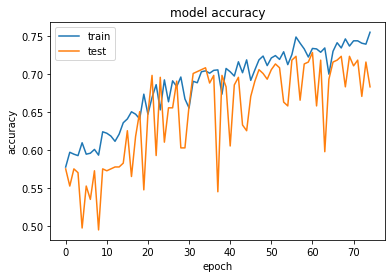

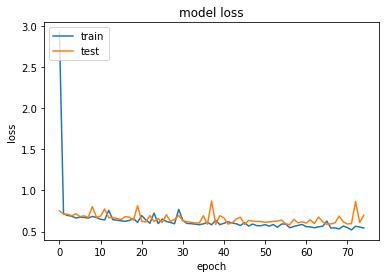

In [50]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=75, batch_size=256,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('lstm.h5')


In [62]:
def wordAttentionWeights(sequenceSentence,weights):
    """
    The same function as the AttentionLayer class.
    """
    uit = np.dot(sequenceSentence, weights[0]) + weights[1]
    uit = np.tanh(uit)

    ait = np.dot(uit, weights[2])
    ait = np.squeeze(ait)
    ait = np.exp(ait)
    ait /= np.sum(ait)
    
    return ait


# Create model from word input to output of dense layer right before the attention layer
hidden_word_encoding_out = Model(inputs=model.input, outputs= model.get_layer('time_distributed').output)
# Load weights from trained attention layer
word_context = model.get_layer('attention').get_weights()
# hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# # Compute context vector using output of dense layer
# ait = wordAttentionWeights(hidden_word_encodings,word_context)

In [63]:
for i in range(0,20):
    #print('data',data[i])
    in_data =data_temp[i].reshape(1,MAX_WORD_NUM)
    y = model.predict(in_data)
    print('result:',y, train_df.iloc[i].toxicity_sentence)
    print('row:',len(train_df.iloc[i].sentence),train_df.iloc[i].sentence)
    hidden_word_encodings = hidden_word_encoding_out.predict(in_data)
     # Compute context vector using output of dense layer
    ait = wordAttentionWeights(hidden_word_encodings,word_context)
    print('attention',(in_data, ait))

result: [[0.40123302]] 1.0
row: 32 because hes a moron and a bigot.
attention (array([[21,  2, 14,  4, 13,  7,  2,  0, 10,  2,  7,  0,  4,  0, 16,  5,
         9,  5,  8,  0,  4,  8, 12,  0,  4,  0, 21,  6, 18,  5,  3,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]]), array([0.00870286, 0.01756554, 0.0137305 , 0.01066535, 0.00850889,
       0.00974164, 0.01372123, 0.01127803, 0.01074357, 0.01596014,
       0.01019212, 0.00824401, 0.00843967, 0.00782706, 0.0062177 ,
       0.00891188, 0.00689358, 0.0096707 , 0.01253579, 0.01102134,
       0.01107235, 0.0151177 , 0.00822037, 0.00760675, 0.00767849,
       0.00816772, 0.00644943, 0.00813946, 0.00678423, 0.00947669,
       0.00913371, 0.00749297, 0.0072714 , 0.00721599, 0.007

attention (array([[ 4,  7,  0, 11,  5,  8, 18,  0,  4,  7,  0, 15,  5, 13,  9,  0,
        19,  6, 11, 11,  6,  8, 18,  0,  3,  5,  0, 17,  4, 15,  0,  4,
         0, 11,  5,  3,  0, 16,  5,  9,  2,  0, 20,  5,  9,  0, 17,  9,
         5, 12, 13, 14,  3,  7,  0, 15,  5, 13,  0, 21, 13, 15,  0,  0,
         3, 10,  2,  8,  0, 20,  6,  8,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]]), array([0.01274565, 0.01088367, 0.00967565, 0.00686921, 0.01116514,
       0.01665053, 0.01225905, 0.01059364, 0.01043977, 0.00940785,
       0.00775334, 0.00489383, 0.00778098, 0.00621567, 0.00685666,
       0.00851856, 0.00819097, 0.00835578, 0.00609487, 0.00633537,
       0.00827126, 0.01598236, 0.01218141, 0.0109896 , 0.01168602,
       0.01355196, 0.01273394, 0.01187419, 0.00905296, 0.00579619,
       0.00753892, 0.0075432 , 0.0083281 , 0.00614744, 0.00958187,
       0.01004794, 0.00912815, 0.00729779, 0.00993485, 0.0089

attention (array([[21,  2, 14,  4, 13,  7,  2,  0,  5, 20,  0, 15,  5, 13,  0,  4,
        11, 11,  0,  3, 10,  2,  0,  7,  3, 13, 17,  6, 12,  0, 20, 13,
        14, 23,  6,  8, 18,  0,  4,  7,  7, 10,  5, 11,  2,  7,  0,  3,
        10,  4,  3,  0, 16,  4, 12,  2,  0, 17,  5,  9,  3, 11,  4,  8,
        12,  0,  4,  0, 17, 11,  4, 14,  2,  0, 20, 13, 11, 11,  0,  5,
        20,  0,  7,  3, 13, 17,  6, 12,  0, 20, 13, 14, 23,  6,  8, 18,
         0,  4,  7,  7]]), array([0.00960905, 0.01935404, 0.01493199, 0.01171029, 0.0097267 ,
       0.01040452, 0.0161167 , 0.01024422, 0.01467627, 0.00977107,
       0.00972912, 0.00597172, 0.00941097, 0.00741169, 0.00893983,
       0.00916099, 0.00640459, 0.0063015 , 0.00982156, 0.01082868,
       0.00994046, 0.01382131, 0.01166268, 0.01032315, 0.01081965,
       0.00757035, 0.00913523, 0.0080883 , 0.00611374, 0.00747303,
       0.00762677, 0.00880182, 0.01149169, 0.0110612 , 0.0088773 ,
       0.01883785, 0.01380671, 0.0125158 , 0.01355624, 0.0125

result: [[1.0875397]] 1.0
row: 63 because driving under ontario laws is stupid enough in ontario.
attention (array([[21,  2, 14,  4, 13,  7,  2,  0, 12,  9,  6, 22,  6,  8, 18,  0,
        13,  8, 12,  2,  9,  0,  5,  8,  3,  4,  9,  6,  5,  0, 11,  4,
        19,  7,  0,  6,  7,  0,  7,  3, 13, 17,  6, 12,  0,  2,  8,  5,
        13, 18, 10,  0,  6,  8,  0,  5,  8,  3,  4,  9,  6,  5,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0]]), array([0.00921915, 0.01822405, 0.01425289, 0.01068216, 0.00889849,
       0.01025722, 0.01414178, 0.01037582, 0.00640318, 0.00603687,
       0.00769888, 0.00888252, 0.0087421 , 0.01285982, 0.00947238,
       0.00872481, 0.00729554, 0.01404557, 0.00791739, 0.01153341,
       0.00811401, 0.00878071, 0.01188206, 0.01517306, 0.01266759,
       0.01101737, 0.00905085, 0.0095273 , 0.01054198, 0.00949618,
       0.00637396, 0.00771717,